# AIPI 590 - XAI | Adversarial Patches

### Mu Niu

The below code chunks were generated using Claude 4.5 Sonnet on 11/2/2025 at 9:32pm.

https://claude.ai/public/artifacts/ff28fbfa-7b4d-4ab9-a79d-97922c58e7ef


#### Load Libs

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import urllib.request
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
from PIL import Image

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

In [4]:
# Paths
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Seed
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cuda:0


#### Download Data and Load Pre-Trained Model

In [6]:
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Download dataset
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]

for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
            if file_name.endswith(".zip"):
                print("Unzipping...")
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(file_path.rsplit("/", 1)[0])
        except Exception as e:
            print(f"Error: {e}")

# Load model
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

for p in pretrained_model.parameters():
    p.requires_grad = False

print("✓ Model loaded")

# Setup dataset
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

print(f"✓ Dataset loaded: {len(dataset)} images")

Unzipping...
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 176MB/s]


✓ Model loaded
✓ Dataset loaded: 5000 images


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Adversarial Patch Function

In [7]:
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN)[:, None, None]
TENSOR_STD = torch.FloatTensor(NORM_STD)[:, None, None]

def patch_forward(patch):
    """Map patch parameters to image space."""
    return (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)

def place_patch(img, patch):
    """Place patch at random location in images."""
    img_copy = img.clone()
    for i in range(img_copy.shape[0]):
        # Random placement
        h_offset = np.random.randint(0, img_copy.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img_copy.shape[3] - patch.shape[2] - 1)
        img_copy[i, :, h_offset:h_offset+patch.shape[1],
                 w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img_copy

def train_optimal_patch(model, target_class, patch_size=64, num_epochs=10):
    """
    Train OPTIMAL adversarial patch with extended training for best performance.
    """
    print(f"\n{'='*70}")
    print(f"TRAINING OPTIMAL PERFORMANCE PATCH")
    print(f"Target: {label_names[target_class]}")
    print(f"Patch size: {patch_size}x{patch_size}")
    print(f"Training epochs: {num_epochs} (extended for best performance)")
    print(f"{'='*70}\n")

    # Split dataset
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True,
                                   drop_last=True, num_workers=4)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                drop_last=False, num_workers=4)

    # Initialize patch with random noise
    patch = nn.Parameter(torch.randn(3, patch_size, patch_size) * 0.1, requires_grad=True)

    # Optimizer with learning rate schedule
    optimizer = torch.optim.SGD([patch], lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=2)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    val_accs = []
    best_patch = None
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_losses = []
        t = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for img, _ in t:
            # Place patch
            img_patched = place_patch(img, patch)
            img_patched = img_patched.to(device)

            # Forward pass
            pred = model(img_patched)

            # Target labels
            labels = torch.zeros(img_patched.shape[0], device=device,
                               dtype=torch.long).fill_(target_class)

            # Loss
            loss = loss_module(pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            t.set_postfix({'loss': f'{loss.item():.3f}'})

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)

        # Validation every epoch
        acc, top5 = eval_patch_quick(model, patch, val_loader, target_class, num_batches=10)
        val_accs.append(acc.item())

        print(f"Epoch {epoch+1:2d}: Loss={avg_loss:.4f} | Top-1={100*acc:.1f}% | Top-5={100*top5:.1f}%")

        # Save best patch
        if acc > best_acc:
            best_acc = acc
            best_patch = patch.data.clone()
            print(f"           ⭐ New best! Saving checkpoint...")

    # Use best patch
    if best_patch is not None:
        patch.data = best_patch

    # Final full evaluation
    print("\n" + "-"*70)
    print("FINAL EVALUATION ON FULL VALIDATION SET")
    print("-"*70)
    acc, top5 = eval_patch_full(model, patch, val_loader, target_class)

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.plot(train_losses, linewidth=2)
    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Training Loss', fontweight='bold')
    ax1.set_title('Training Loss Curve', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    ax2.plot(val_accs, linewidth=2, label='Top-1 Accuracy')
    ax2.axhline(y=best_acc.item(), color='r', linestyle='--', label=f'Best: {100*best_acc:.1f}%')
    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('Validation Accuracy', fontweight='bold')
    ax2.set_title('Validation Accuracy Curve', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    results = {
        "acc": acc.item(),
        "top5": top5.item(),
        "train_losses": train_losses,
        "val_accs": val_accs,
        "best_acc": best_acc.item()
    }

    print(f"\n✓ Training Complete!")
    print(f"  Final Top-1 Success Rate: {100*acc:.2f}%")
    print(f"  Final Top-5 Success Rate: {100*top5:.2f}%")

    return patch.data, results

def eval_patch_quick(model, patch, val_loader, target_class, num_batches=10):
    """Quick evaluation on subset of data."""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for batch_idx, (img, img_labels) in enumerate(val_loader):
            if batch_idx >= num_batches:
                break

            # Apply patch twice for stability
            for _ in range(2):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                # Exclude images that are already target class
                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

    return tp/counter if counter > 0 else 0, tp_5/counter if counter > 0 else 0

def eval_patch_full(model, patch, val_loader, target_class):
    """Full evaluation on entire validation set."""
    model.eval()
    tp, tp_5, counter = 0., 0., 0.

    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Evaluating", leave=False):
            # Test at multiple positions
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)

                pred = model(patch_img)

                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

    return tp/counter, tp_5/counter

#### Creative Styling

In [8]:
try:
    import qrcode
except ModuleNotFoundError:
    !pip install qrcode[pil]
    import qrcode

def create_qr_code_mask(size=64, message="AI Security Research"):
    """Create QR code pattern to use as styling mask."""
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=1,
    )
    qr.add_data(message)
    qr.make(fit=True)

    qr_img = qr.make_image(fill_color="black", back_color="white")
    qr_img = qr_img.resize((size, size), Image.LANCZOS)
    qr_array = np.array(qr_img.convert('RGB')).astype(np.float32) / 255.0
    qr_tensor = torch.from_numpy(qr_array).permute(2, 0, 1)

    return qr_tensor

def style_as_qr_code(patch, qr_blend=0.25):
    """Style patch to look like QR code."""
    qr_template = create_qr_code_mask(size=patch.shape[1])

    patch_display = torch.tanh(patch)
    qr_display = 2 * qr_template - 1

    styled = patch_display + qr_blend * (qr_display - patch_display)
    styled_patch = torch.atanh(torch.clamp(styled, -0.999, 0.999))

    return styled_patch

def style_as_barcode(patch, stripe_width=3):
    """Style patch to look like a barcode."""
    patch_vis = torch.tanh(patch)

    # Create vertical stripe pattern
    stripes = torch.zeros_like(patch_vis[0])
    for i in range(0, patch_vis.shape[2], stripe_width * 2):
        stripes[:, i:i+stripe_width] = 1.0

    # Apply stripes
    blend_factor = 0.3
    for c in range(3):
        styled = patch_vis[c] + blend_factor * (2 * stripes - 1 - patch_vis[c])
        patch_vis[c] = styled

    styled_patch = torch.atanh(torch.clamp(patch_vis, -0.999, 0.999))
    return styled_patch

def add_border(patch, border_width=2, border_color='white'):
    """Add a clean border around the patch."""
    patch_vis = torch.tanh(patch)

    if border_color == 'black':
        color_val = -1.0
    elif border_color == 'white':
        color_val = 1.0
    else:
        color_val = 0.0

    patch_vis[:, :border_width, :] = color_val
    patch_vis[:, -border_width:, :] = color_val
    patch_vis[:, :, :border_width] = color_val
    patch_vis[:, :, -border_width:] = color_val

    styled_patch = torch.atanh(torch.clamp(patch_vis, -0.999, 0.999))
    return styled_patch

def compare_creative_styles(original_patch, target_class):
    """
    Test different creative styling options (QR codes and barcodes)
    and compare their effectiveness.
    """
    print("\n" + "="*70)
    print("CREATIVE STYLING COMPARISON: QR CODES & BARCODES")
    print("="*70)

    # Create styled versions with different parameters
    styles = {
        'Original (No Styling)': original_patch,
        'QR Code (Light 15%)': style_as_qr_code(original_patch, qr_blend=0.15),
        'QR Code (Medium 25%)': style_as_qr_code(original_patch, qr_blend=0.25),
        'QR Code (Strong 35%)': style_as_qr_code(original_patch, qr_blend=0.35),
        'Barcode (Thin Lines)': style_as_barcode(original_patch, stripe_width=2),
        'Barcode (Medium Lines)': style_as_barcode(original_patch, stripe_width=3),
        'Barcode (Thick Lines)': style_as_barcode(original_patch, stripe_width=4),
    }

    # Test each style
    val_set = torch.utils.data.random_split(dataset, [4500, 500])[1]
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                 drop_last=False, num_workers=4)

    results = {}
    print("\nTesting styled patches (this may take a moment)...")
    print("-" * 70)

    for style_name, styled_patch in styles.items():
        acc, top5 = eval_patch_quick(pretrained_model, styled_patch,
                                     val_loader, target_class, num_batches=15)
        results[style_name] = {'acc': acc.item(), 'top5': top5.item()}
        print(f"{style_name:30s} → Top-1: {100*acc:5.1f}%  Top-5: {100*top5:5.1f}%")

    # Visualize all styles
    print("\n" + "="*70)
    print("VISUAL COMPARISON")
    print("="*70)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, (style_name, styled_patch) in enumerate(styles.items()):
        if idx >= len(axes):
            break

        patch_vis = (torch.tanh(styled_patch) + 1) / 2
        patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
        patch_vis = np.clip(patch_vis, 0, 1)

        axes[idx].imshow(patch_vis)
        acc = results[style_name]['acc']
        top5 = results[style_name]['top5']
        axes[idx].set_title(f"{style_name}\nTop-1: {100*acc:.1f}% | Top-5: {100*top5:.1f}%",
                           fontweight='bold', fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots
    for idx in range(len(styles), len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f"Creative Style Comparison - Target: {label_names[target_class]}",
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # Performance comparison chart
    print("\n" + "="*70)
    print("PERFORMANCE ANALYSIS")
    print("="*70)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Bar chart
    style_names = list(results.keys())
    top1_accs = [results[s]['acc'] * 100 for s in style_names]
    top5_accs = [results[s]['top5'] * 100 for s in style_names]

    x = np.arange(len(style_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, top1_accs, width, label='Top-1', alpha=0.8)
    bars2 = ax1.bar(x + width/2, top5_accs, width, label='Top-5', alpha=0.8)

    ax1.set_xlabel('Style', fontweight='bold')
    ax1.set_ylabel('Success Rate (%)', fontweight='bold')
    ax1.set_title('Performance Comparison', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(style_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 100])

    # Performance drop from original
    original_acc = results['Original (No Styling)']['acc']
    drops = [(original_acc - results[s]['acc']) * 100 for s in style_names[1:]]

    colors = ['green' if d < 5 else 'orange' if d < 10 else 'red' for d in drops]
    ax2.barh(style_names[1:], drops, color=colors, alpha=0.7)
    ax2.set_xlabel('Performance Drop (%)', fontweight='bold')
    ax2.set_title('Performance Loss from Original', fontweight='bold')
    ax2.axvline(x=5, color='green', linestyle='--', alpha=0.5, label='<5% (Excellent)')
    ax2.axvline(x=10, color='orange', linestyle='--', alpha=0.5, label='<10% (Good)')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Recommendations
    print("\n" + "="*70)
    print("RECOMMENDATIONS")
    print("="*70)

    best_overall = max(results.items(), key=lambda x: x[1]['acc'])
    print(f"\n✓ Best Overall Performance: {best_overall[0]}")
    print(f"  Success rate: {100*best_overall[1]['acc']:.1f}%")

    # Best QR code
    qr_styles = {k: v for k, v in results.items() if 'QR Code' in k}
    best_qr = max(qr_styles.items(), key=lambda x: x[1]['acc'])
    qr_drop = (original_acc - best_qr[1]['acc']) * 100
    print(f"\n✓ Best QR Code Style: {best_qr[0]}")
    print(f"  Success rate: {100*best_qr[1]['acc']:.1f}%")
    print(f"  Performance drop: {qr_drop:.1f}%")
    if qr_drop < 5:
        print(f"  → EXCELLENT! Minimal performance loss")
    elif qr_drop < 10:
        print(f"  → GOOD! Acceptable performance trade-off")
    else:
        print(f"  → Consider lighter styling")

    # Best Barcode
    barcode_styles = {k: v for k, v in results.items() if 'Barcode' in k}
    best_barcode = max(barcode_styles.items(), key=lambda x: x[1]['acc'])
    barcode_drop = (original_acc - best_barcode[1]['acc']) * 100
    print(f"\n✓ Best Barcode Style: {best_barcode[0]}")
    print(f"  Success rate: {100*best_barcode[1]['acc']:.1f}%")
    print(f"  Performance drop: {barcode_drop:.1f}%")
    if barcode_drop < 5:
        print(f"  → EXCELLENT! Minimal performance loss")
    elif barcode_drop < 10:
        print(f"  → GOOD! Acceptable performance trade-off")
    else:
        print(f"  → Consider lighter styling")

    # Final recommendation
    print("\n" + "-"*70)
    if best_qr[1]['acc'] > best_barcode[1]['acc']:
        print(f"🎯 FINAL RECOMMENDATION: Use {best_qr[0]}")
        print(f"   Offers best balance of creativity and effectiveness!")
        return best_qr[0], styles[best_qr[0]]
    else:
        print(f"🎯 FINAL RECOMMENDATION: Use {best_barcode[0]}")
        print(f"   Offers best balance of creativity and effectiveness!")
        return best_barcode[0], styles[best_barcode[0]]

#### Visualization Function

In [9]:
def show_prediction(img, label, pred, K=5, adv_img=None, patch=None):
    """Visualize predictions."""
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        img = np.clip(img, 0, 1)
        label = label.item()

    if adv_img is not None and patch is not None:
        fig, ax = plt.subplots(1, 4, figsize=(16, 3),
                              gridspec_kw={'width_ratios': [1, 1, 1, 2]})
    else:
        fig, ax = plt.subplots(1, 2, figsize=(10, 3),
                              gridspec_kw={'width_ratios': [1, 2]})

    # Original
    ax[0].imshow(img)
    ax[0].set_title(f'Original: {label_names[label]}', fontweight='bold')
    ax[0].axis('off')

    if adv_img is not None and patch is not None:
        # Adversarial
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        adv_img = np.clip(adv_img, 0, 1)
        ax[1].imshow(adv_img)
        ax[1].set_title('With Patch', fontweight='bold')
        ax[1].axis('off')

        # Patch
        patch_vis = (torch.tanh(patch) + 1) / 2
        patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
        patch_vis = np.clip(patch_vis, 0, 1)
        ax[2].imshow(patch_vis)
        ax[2].set_title('Adversarial Patch', fontweight='bold')
        ax[2].axis('off')

    # Predictions
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    colors = ["C2" if topk_idx[i] == label else "C0" for i in range(K)]
    ax[-1].barh(np.arange(K), topk_vals * 100.0, align='center', color=colors)
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence (%)', fontweight='bold')
    ax[-1].set_title('Top-5 Predictions', fontweight='bold')
    ax[-1].set_xlim([0, 100])

    plt.tight_layout()
    plt.show()

def demonstrate_patch(patch, target_class, patch_name="Patch", num_examples=6):
    """Show patch effectiveness on multiple images."""
    exmp_batch, label_batch = next(iter(data_loader))

    print(f"\n{'='*70}")
    print(f"DEMONSTRATION: {patch_name}")
    print(f"Target: {label_names[target_class]}")
    print(f"{'='*70}\n")

    # Show the patch
    patch_vis = (torch.tanh(patch) + 1) / 2
    patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
    patch_vis = np.clip(patch_vis, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(patch_vis)
    plt.title(f'{patch_name}\nTarget: {label_names[target_class]}',
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"\n{patch_name} Effects on Sample Images:")
    print("-" * 70)

    # Show examples
    for i in range(min(num_examples, len(exmp_batch))):
        with torch.no_grad():
            orig_pred = pretrained_model(exmp_batch[i:i+1].to(device))

        # Create adversarial
        adv_batch = exmp_batch[i:i+1].clone()
        h_offset = np.random.randint(0, adv_batch.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, adv_batch.shape[3] - patch.shape[2] - 1)
        adv_batch[0, :, h_offset:h_offset+patch.shape[1],
                  w_offset:w_offset+patch.shape[2]] = patch_forward(patch)

        with torch.no_grad():
            adv_pred = pretrained_model(adv_batch.to(device))

        show_prediction(exmp_batch[i], label_batch[i], adv_pred[0],
                       adv_img=adv_batch[0], patch=patch)

def save_patch_for_printing(patch, target_name, filename=None, size_inches=4, dpi=300):
    """Save high-resolution patch for printing."""
    if filename is None:
        filename = f"{target_name.replace(' ', '_')}_patch.png"

    # Convert to image
    patch_vis = (torch.tanh(patch) + 1) / 2
    patch_vis = patch_vis.cpu().permute(1, 2, 0).numpy()
    patch_vis = np.clip(patch_vis, 0, 1)
    patch_vis = (patch_vis * 255).astype(np.uint8)

    # Create PIL image
    img = Image.fromarray(patch_vis)

    # Resize to print resolution
    size_pixels = int(size_inches * dpi)
    img = img.resize((size_pixels, size_pixels), Image.LANCZOS)

    # Save
    img.save(filename, dpi=(dpi, dpi))
    print(f"\n✓ Patch saved: '{filename}'")
    print(f"  Size: {size_inches}x{size_inches} inches at {dpi} DPI")
    print(f"  Resolution: {size_pixels}x{size_pixels} pixels")

    return filename

#### Main

In [10]:
def main():
    """Main execution: Train optimal patch, then apply creative styling."""

    print("\n" + "="*70)
    print("PERFORMANCE-FIRST ADVERSARIAL PATCH WITH CREATIVE STYLING")
    print("="*70)

    # Target selection
    recommended_targets = [
        'toaster', 'website', 'comic book', 'spotlight',
        'basketball', 'traffic light', 'iPod', 'bannister'
    ]

    print("\nRecommended targets:")
    for i, target in enumerate(recommended_targets, 1):
        print(f"  {i}. {target}")

    target_name = 'toaster'  # Change as needed
    target_class = label_names.index(target_name)
    print(f"\nSelected target: '{target_name}' (class index {target_class})")

    # ========================================================================
    # STEP 1: Train OPTIMAL performance patch with extended epochs
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: TRAINING OPTIMAL PERFORMANCE PATCH")
    print("="*70)
    print("\nTraining with extended epochs for maximum effectiveness...")

    original_patch, train_results = train_optimal_patch(
        model=pretrained_model,
        target_class=target_class,
        patch_size=64,
        num_epochs=10  # Extended training for best performance
    )

    print(f"\n✓ Optimal patch achieved: {100*train_results['acc']:.1f}% success rate")

    # ========================================================================
    # STEP 2: Test creative styling options (QR codes & barcodes)
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: TESTING CREATIVE STYLING OPTIONS")
    print("="*70)
    print("\nComparing QR code and barcode styling while maintaining performance...")

    best_style_name, best_styled_patch = compare_creative_styles(
        original_patch, target_class
    )

    # ========================================================================
    # STEP 3: Final evaluation and comparison
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: FINAL EVALUATION")
    print("="*70)

    val_set = torch.utils.data.random_split(dataset, [4500, 500])[1]
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False,
                                 drop_last=False, num_workers=4)

    print("\nEvaluating best styled patch on full validation set...")
    final_acc, final_top5 = eval_patch_full(pretrained_model, best_styled_patch,
                                            val_loader, target_class)

    # Create summary visualization
    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY")
    print("="*70)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Original patch
    orig_vis = (torch.tanh(original_patch) + 1) / 2
    orig_vis = orig_vis.cpu().permute(1, 2, 0).numpy()
    orig_vis = np.clip(orig_vis, 0, 1)
    axes[0].imshow(orig_vis)
    axes[0].set_title(f'Original Patch\nPerformance: {100*train_results["acc"]:.1f}%',
                     fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Best styled patch
    styled_vis = (torch.tanh(best_styled_patch) + 1) / 2
    styled_vis = styled_vis.cpu().permute(1, 2, 0).numpy()
    styled_vis = np.clip(styled_vis, 0, 1)
    axes[1].imshow(styled_vis)
    axes[1].set_title(f'{best_style_name}\nPerformance: {100*final_acc:.1f}%',
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Performance comparison
    categories = ['Top-1\nSuccess', 'Top-5\nSuccess']
    original_scores = [train_results['acc'] * 100, train_results['top5'] * 100]
    styled_scores = [final_acc.item() * 100, final_top5.item() * 100]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = axes[2].bar(x - width/2, original_scores, width, label='Original', alpha=0.8)
    bars2 = axes[2].bar(x + width/2, styled_scores, width, label=best_style_name, alpha=0.8)

    axes[2].set_ylabel('Success Rate (%)', fontweight='bold', fontsize=12)
    axes[2].set_title('Performance Comparison', fontweight='bold', fontsize=14)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(categories, fontsize=11)
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3, axis='y')
    axes[2].set_ylim([0, 100])

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.suptitle(f'Final Results - Target: {label_names[target_class]}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Original patch: {100*train_results['acc']:.1f}% success")
    print(f"✓ Styled patch: {100*final_acc:.1f}% success")
    print(f"✓ Performance drop: {100*(train_results['acc']-final_acc):.1f}%")

    # ========================================================================
    # STEP 4: Demonstrate both patches on sample images
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUAL DEMONSTRATIONS")
    print("="*70)

    print("\n📊 Demonstrating ORIGINAL patch:")
    demonstrate_patch(original_patch, target_class,
                     patch_name="Original Patch", num_examples=4)

    print("\n📊 Demonstrating STYLED patch:")
    demonstrate_patch(best_styled_patch, target_class,
                     patch_name=best_style_name, num_examples=4)

    # ========================================================================
    # STEP 5: Save patches for printing
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: SAVING PATCHES FOR PRINTING")
    print("="*70)

    # Save original
    orig_filename = f"{target_name.replace(' ', '_')}_original.png"
    save_patch_for_printing(original_patch, f"{target_name} (Original)",
                           filename=orig_filename, size_inches=4, dpi=300)

    # Save styled
    styled_filename = f"{target_name.replace(' ', '_')}_styled.png"
    save_patch_for_printing(best_styled_patch, f"{target_name} ({best_style_name})",
                           filename=styled_filename, size_inches=4, dpi=300)

    # Create instruction sheet
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Original patch
    axes[0, 0].imshow(orig_vis)
    axes[0, 0].set_title('ORIGINAL PATCH', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    # Styled patch
    axes[0, 1].imshow(styled_vis)
    axes[0, 1].set_title(f'STYLED PATCH ({best_style_name})', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # Instructions for original
    axes[1, 0].axis('off')
    instructions_orig = f"""
    ORIGINAL PATCH
    ━━━━━━━━━━━━━━━━━━━━━━━━━━

    Performance: {100*train_results['acc']:.1f}%
    Target: {target_name.upper()}

    PRINTING:
    • Size: 4" x 4"
    • Paper: Glossy photo paper
    • Quality: Highest
    • Color printing required

    TESTING:
    • Distance: 1-3 feet
    • Good lighting needed
    • Test at multiple angles

    File: {orig_filename}
    """
    axes[1, 0].text(0.1, 0.5, instructions_orig, fontsize=10, family='monospace',
                   verticalalignment='center')

    # Instructions for styled
    axes[1, 1].axis('off')
    instructions_styled = f"""
    STYLED PATCH
    ━━━━━━━━━━━━━━━━━━━━━━━━━━

    Performance: {100*final_acc:.1f}%
    Target: {target_name.upper()}
    Style: {best_style_name}

    PRINTING:
    • Size: 4" x 4"
    • Paper: Glossy photo paper
    • Quality: Highest
    • Color printing required

    TESTING:
    • Distance: 1-3 feet
    • Good lighting needed
    • Test at multiple angles

    File: {styled_filename}
    """
    axes[1, 1].text(0.1, 0.5, instructions_styled, fontsize=10, family='monospace',
                   verticalalignment='center')

    plt.suptitle(f'PRINTING INSTRUCTIONS - Target: {label_names[target_class]}',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    instruction_file = f"{target_name.replace(' ', '_')}_instructions.png"
    plt.savefig(instruction_file, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Instruction sheet saved: '{instruction_file}'")

    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    print("\n" + "="*70)
    print("✨ FINAL SUMMARY ✨")
    print("="*70)
    print(f"\n🎯 Target: {label_names[target_class]}")
    print(f"\n📊 ORIGINAL PATCH:")
    print(f"   • Success rate: {100*train_results['acc']:.1f}%")
    print(f"   • Top-5 rate: {100*train_results['top5']:.1f}%")
    print(f"   • File: {orig_filename}")

    print(f"\n🎨 STYLED PATCH ({best_style_name}):")
    print(f"   • Success rate: {100*final_acc:.1f}%")
    print(f"   • Top-5 rate: {100*final_top5:.1f}%")
    print(f"   • Performance drop: {100*(train_results['acc']-final_acc):.1f}%")
    print(f"   • File: {styled_filename}")

    performance_drop = (train_results['acc'] - final_acc.item()) * 100

    if final_acc > 0.70:
        emoji = "🎉"
        rating = "EXCELLENT"
        comment = "Outstanding performance with creative styling!"
    elif final_acc > 0.60:
        emoji = "✅"
        rating = "VERY GOOD"
        comment = "Great balance of creativity and effectiveness!"
    elif final_acc > 0.50:
        emoji = "👍"
        rating = "GOOD"
        comment = "Acceptable performance with creative design!"
    else:
        emoji = "⚠️"
        rating = "MODERATE"
        comment = "Consider using lighter styling or original patch."

    print(f"\n{emoji} OVERALL RATING: {rating}")
    print(f"   {comment}")

    if performance_drop < 5:
        print(f"\n💎 Minimal performance loss (<5%) - Perfect balance achieved!")
    elif performance_drop < 10:
        print(f"\n✨ Small performance trade-off (<10%) - Excellent result!")
    elif performance_drop < 15:
        print(f"\n👌 Moderate trade-off (<15%) - Good creative option!")
    else:
        print(f"\n💡 Consider: Original patch or lighter styling for better performance")

    print("\n📁 Files ready for physical testing!")
    print("="*70 + "\n")

    return {
        'original_patch': original_patch,
        'styled_patch': best_styled_patch,
        'style_name': best_style_name,
        'original_acc': train_results['acc'],
        'styled_acc': final_acc.item(),
        'target_name': target_name,
        'target_class': target_class
    }


PERFORMANCE-FIRST ADVERSARIAL PATCH WITH CREATIVE STYLING

Recommended targets:
  1. toaster
  2. website
  3. comic book
  4. spotlight
  5. basketball
  6. traffic light
  7. iPod
  8. bannister

Selected target: 'toaster' (class index 859)

STEP 1: TRAINING OPTIMAL PERFORMANCE PATCH

Training with extended epochs for maximum effectiveness...

TRAINING OPTIMAL PERFORMANCE PATCH
Target: toaster
Patch size: 64x64
Training epochs: 10 (extended for best performance)



Epoch 1/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  1: Loss=4.3139 | Top-1=88.4% | Top-5=98.9%
           ⭐ New best! Saving checkpoint...


Epoch 2/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  2: Loss=0.2872 | Top-1=96.4% | Top-5=99.8%
           ⭐ New best! Saving checkpoint...


Epoch 3/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  3: Loss=0.1463 | Top-1=96.4% | Top-5=99.8%


Epoch 4/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  4: Loss=0.1235 | Top-1=96.9% | Top-5=100.0%
           ⭐ New best! Saving checkpoint...


Epoch 5/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  5: Loss=0.0953 | Top-1=98.3% | Top-5=100.0%
           ⭐ New best! Saving checkpoint...


Epoch 6/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  6: Loss=0.0820 | Top-1=98.3% | Top-5=100.0%


Epoch 7/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  7: Loss=0.0592 | Top-1=99.2% | Top-5=100.0%
           ⭐ New best! Saving checkpoint...


Epoch 8/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  8: Loss=0.0612 | Top-1=98.6% | Top-5=100.0%


Epoch 9/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch  9: Loss=0.0566 | Top-1=98.9% | Top-5=100.0%


Epoch 10/10:   0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10: Loss=0.0459 | Top-1=98.8% | Top-5=99.7%

----------------------------------------------------------------------
FINAL EVALUATION ON FULL VALIDATION SET
----------------------------------------------------------------------


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

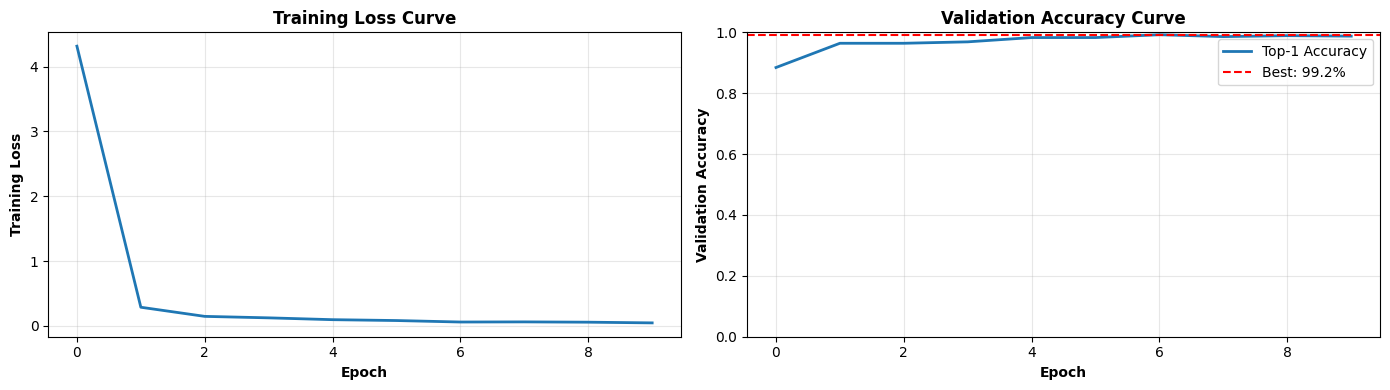


✓ Training Complete!
  Final Top-1 Success Rate: 98.25%
  Final Top-5 Success Rate: 99.95%

✓ Optimal patch achieved: 98.3% success rate

STEP 2: TESTING CREATIVE STYLING OPTIONS

Comparing QR code and barcode styling while maintaining performance...

CREATIVE STYLING COMPARISON: QR CODES & BARCODES

Testing styled patches (this may take a moment)...
----------------------------------------------------------------------
Original (No Styling)          → Top-1:  97.9%  Top-5:  99.9%
QR Code (Light 15%)            → Top-1:  47.6%  Top-5:  77.6%
QR Code (Medium 25%)           → Top-1:   0.8%  Top-5:   5.2%
QR Code (Strong 35%)           → Top-1:   0.1%  Top-5:   0.2%
Barcode (Thin Lines)           → Top-1:   1.6%  Top-5:   6.2%
Barcode (Medium Lines)         → Top-1:   4.6%  Top-5:  15.6%
Barcode (Thick Lines)          → Top-1:  13.2%  Top-5:  30.6%

VISUAL COMPARISON


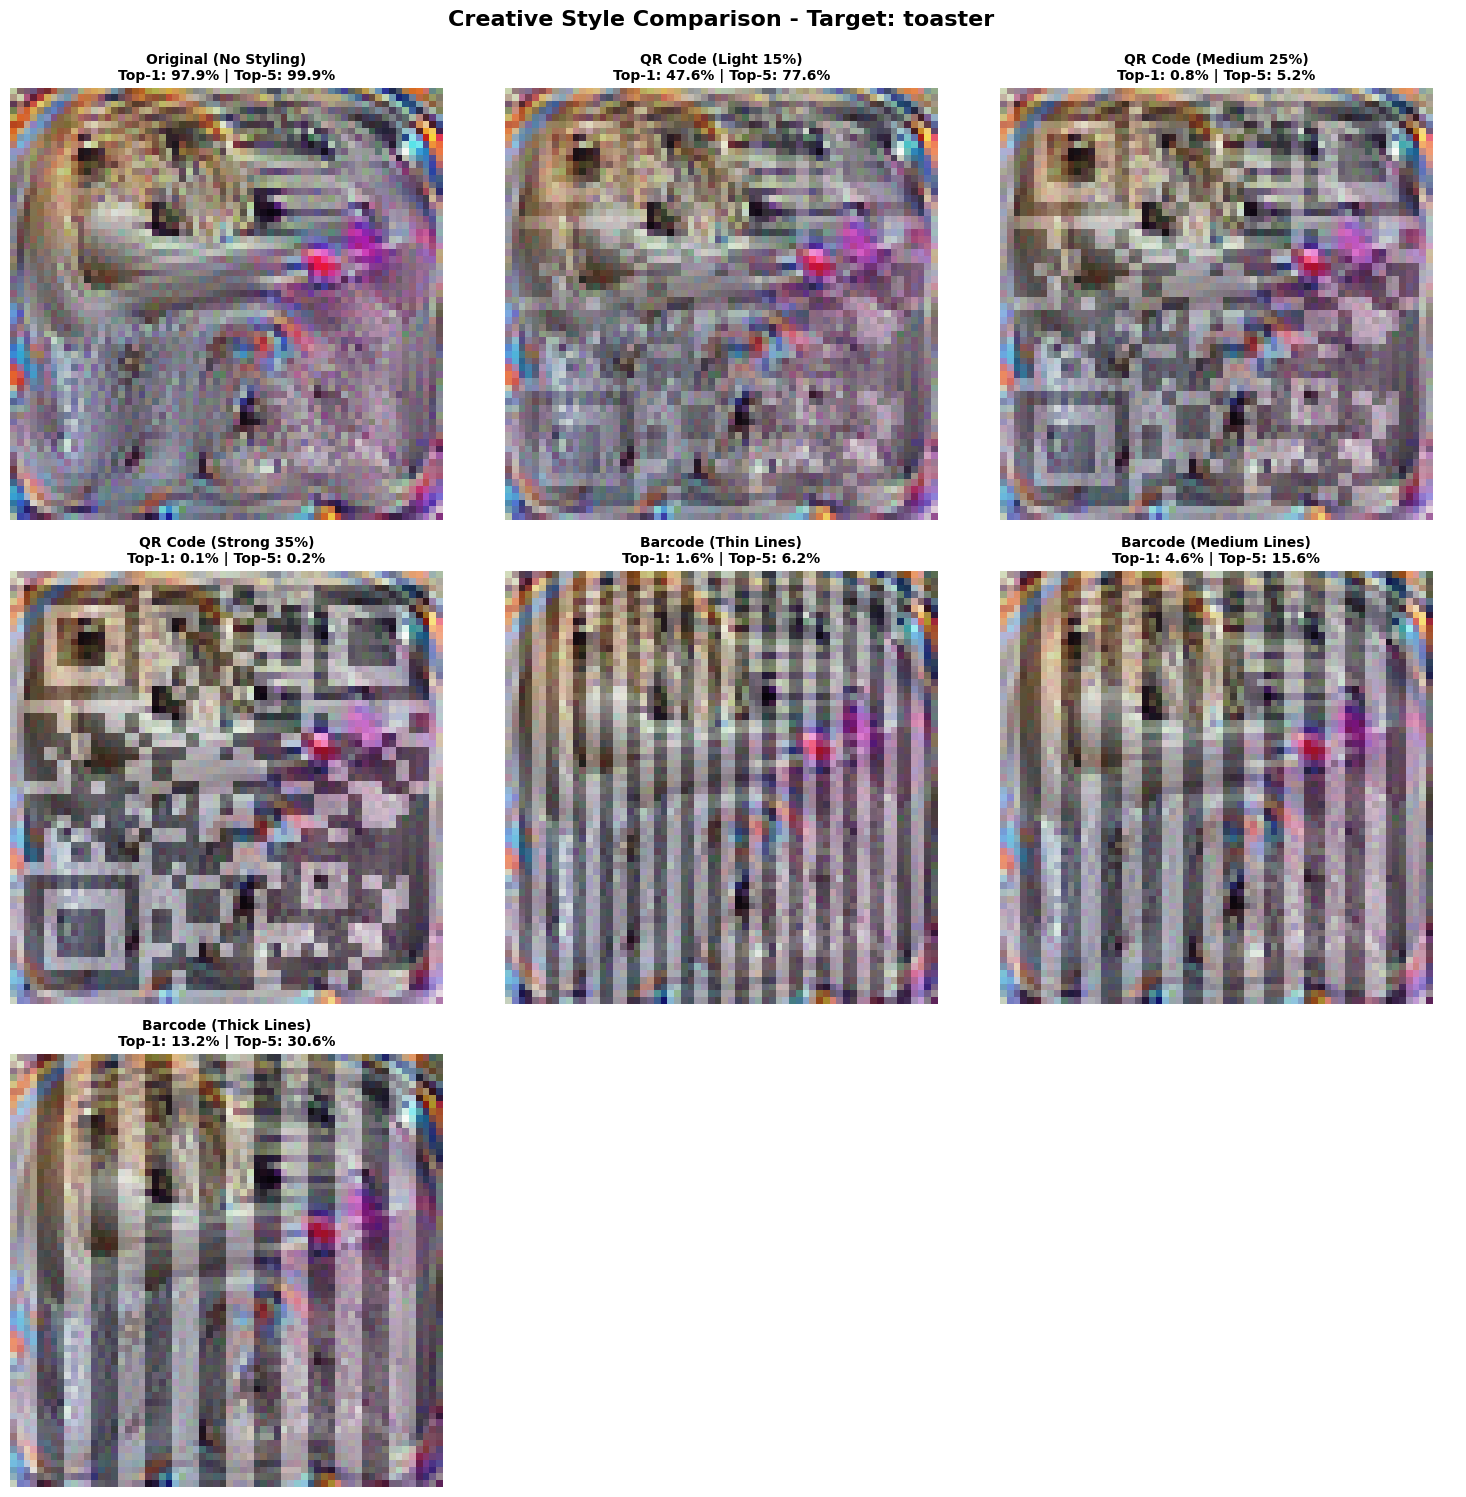


PERFORMANCE ANALYSIS


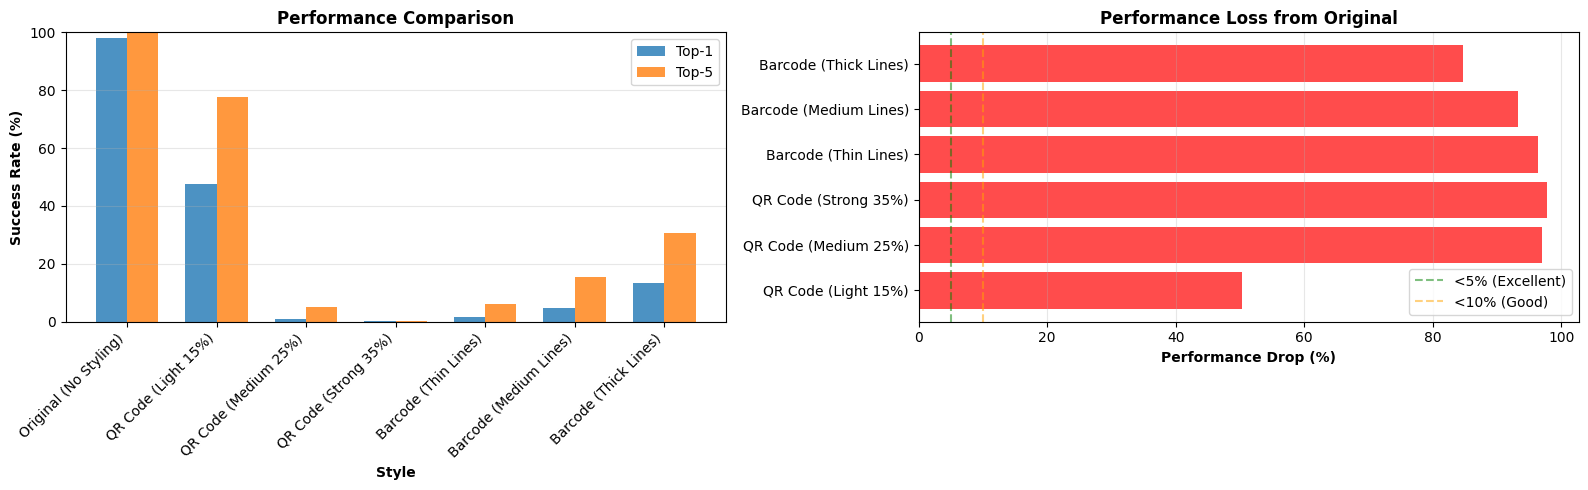


RECOMMENDATIONS

✓ Best Overall Performance: Original (No Styling)
  Success rate: 97.9%

✓ Best QR Code Style: QR Code (Light 15%)
  Success rate: 47.6%
  Performance drop: 50.3%
  → Consider lighter styling

✓ Best Barcode Style: Barcode (Thick Lines)
  Success rate: 13.2%
  Performance drop: 84.7%
  → Consider lighter styling

----------------------------------------------------------------------
🎯 FINAL RECOMMENDATION: Use QR Code (Light 15%)
   Offers best balance of creativity and effectiveness!

STEP 3: FINAL EVALUATION

Evaluating best styled patch on full validation set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


PERFORMANCE SUMMARY


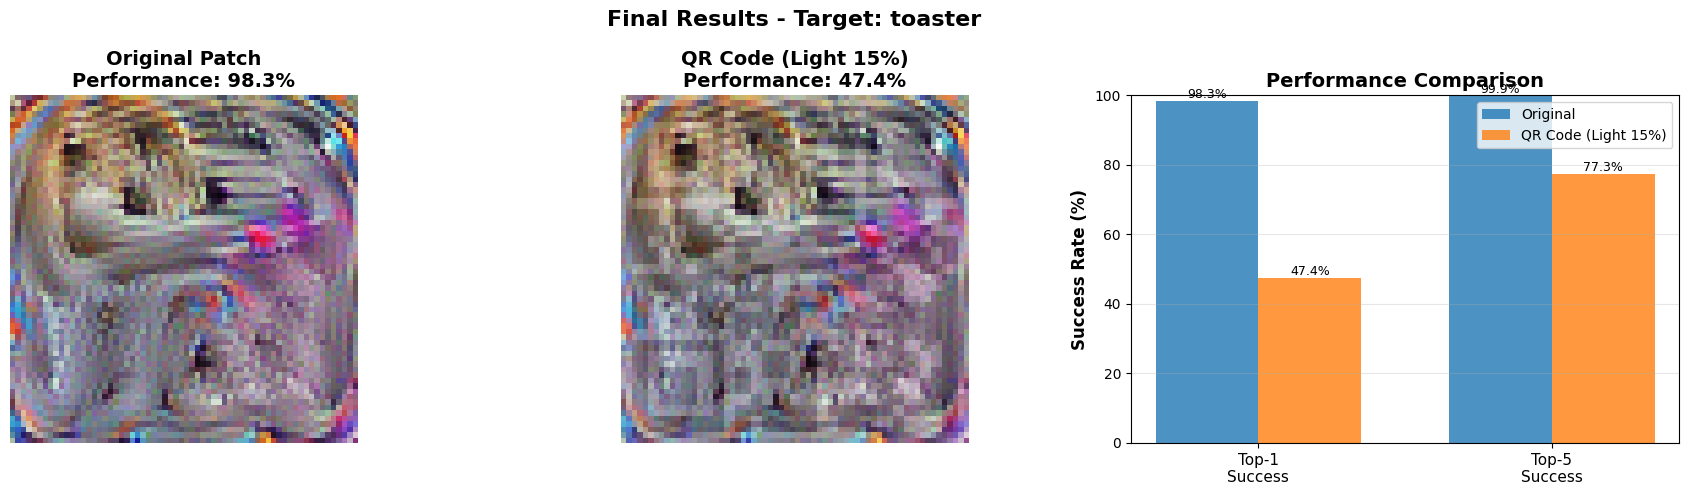


✓ Original patch: 98.3% success
✓ Styled patch: 47.4% success
✓ Performance drop: 50.9%

STEP 4: VISUAL DEMONSTRATIONS

📊 Demonstrating ORIGINAL patch:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



DEMONSTRATION: Original Patch
Target: toaster



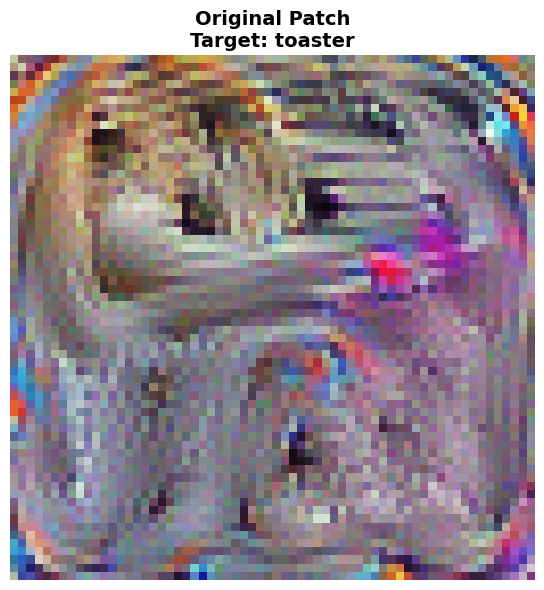


Original Patch Effects on Sample Images:
----------------------------------------------------------------------


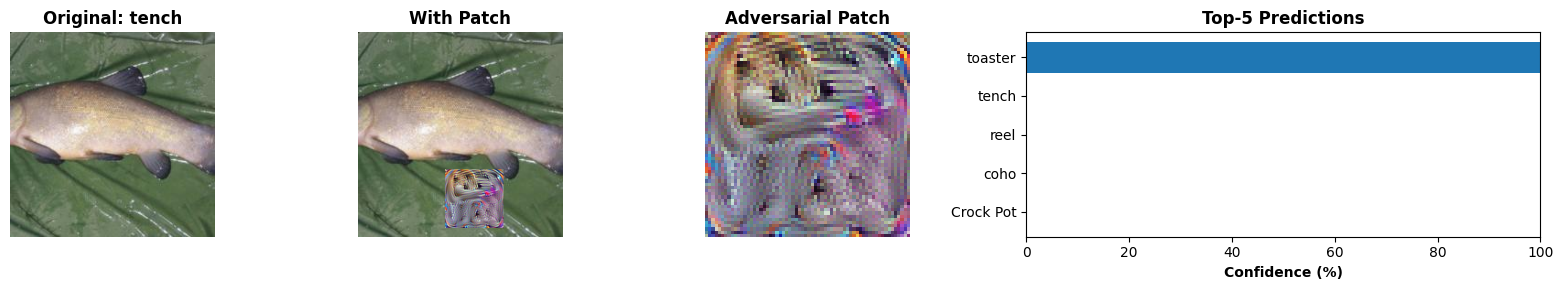

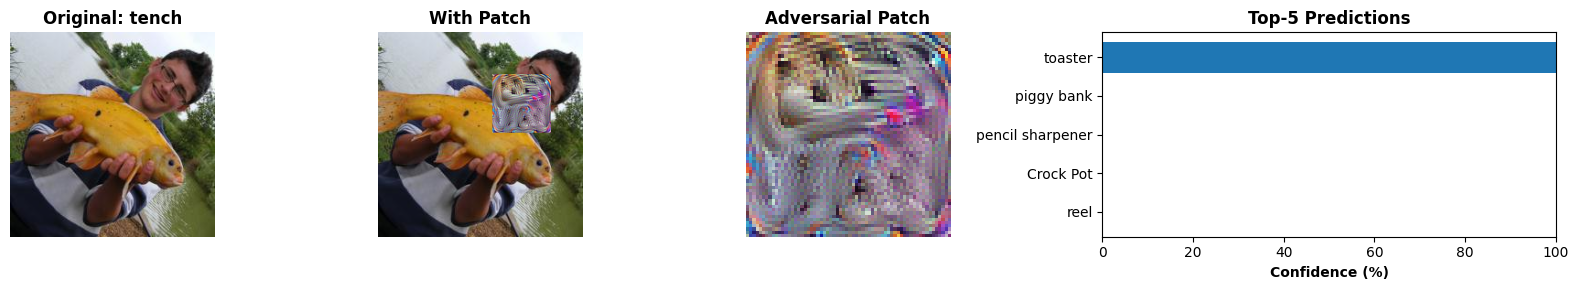

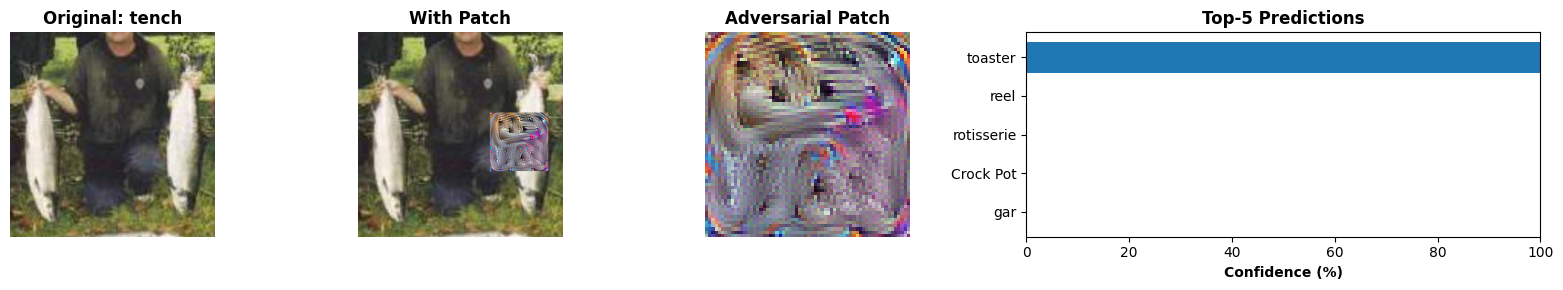

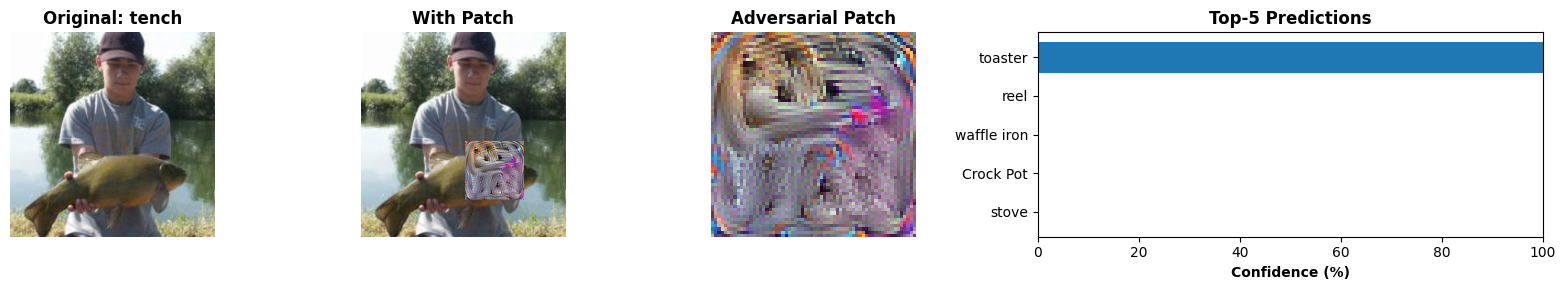


📊 Demonstrating STYLED patch:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



DEMONSTRATION: QR Code (Light 15%)
Target: toaster



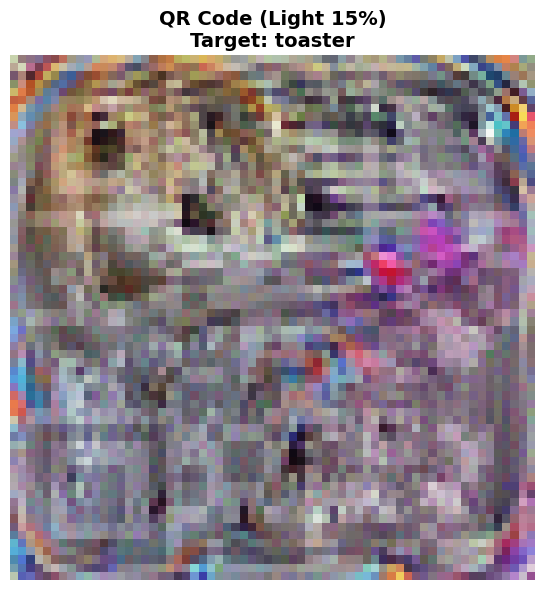


QR Code (Light 15%) Effects on Sample Images:
----------------------------------------------------------------------


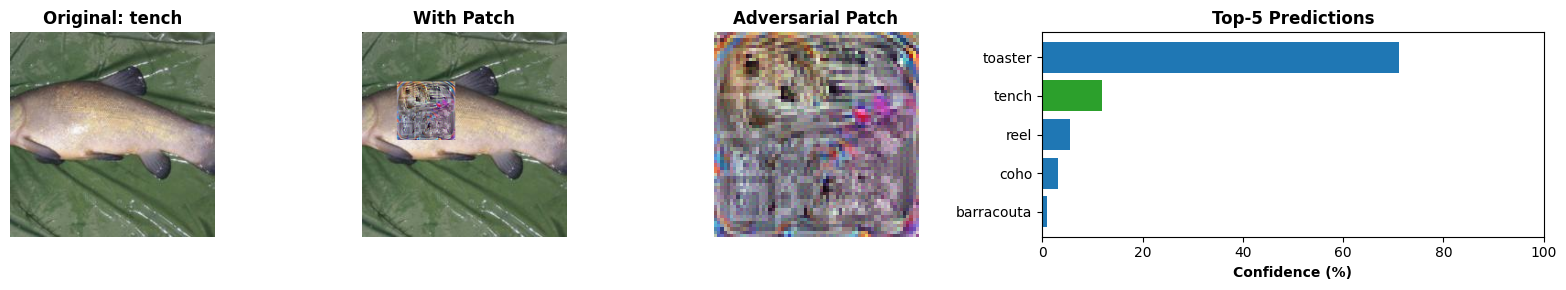

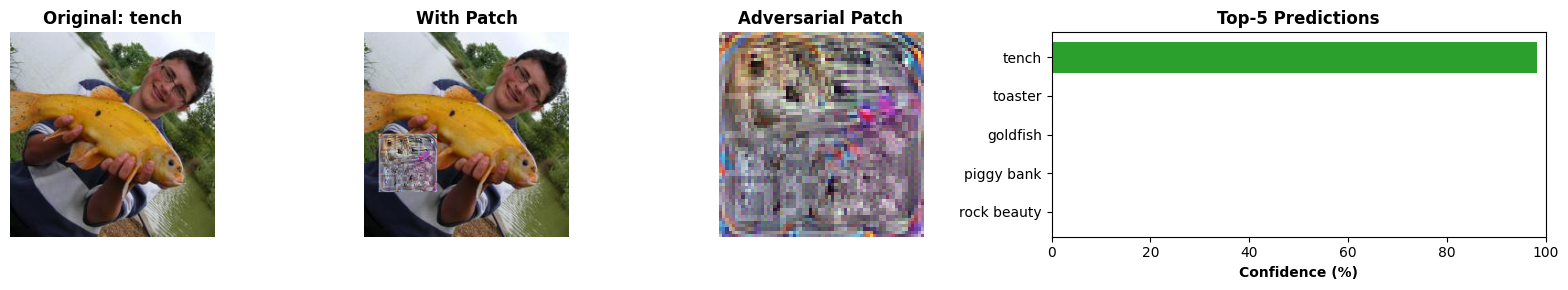

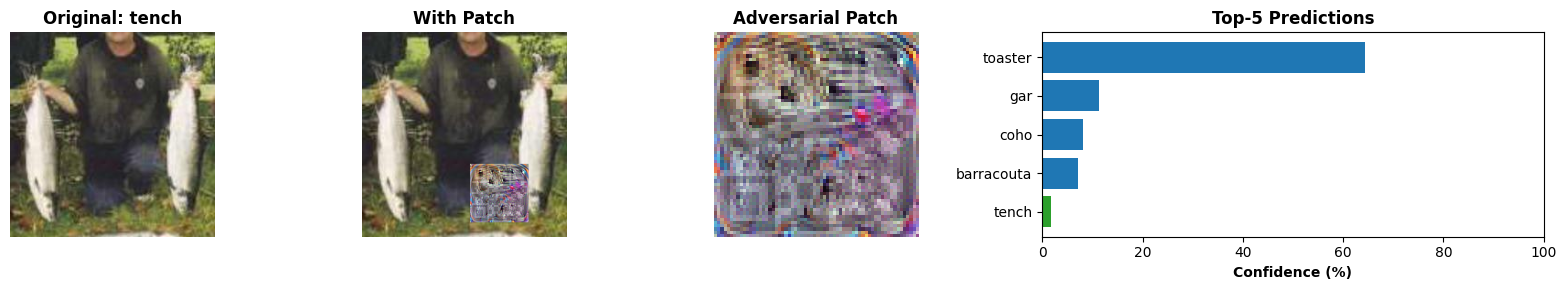

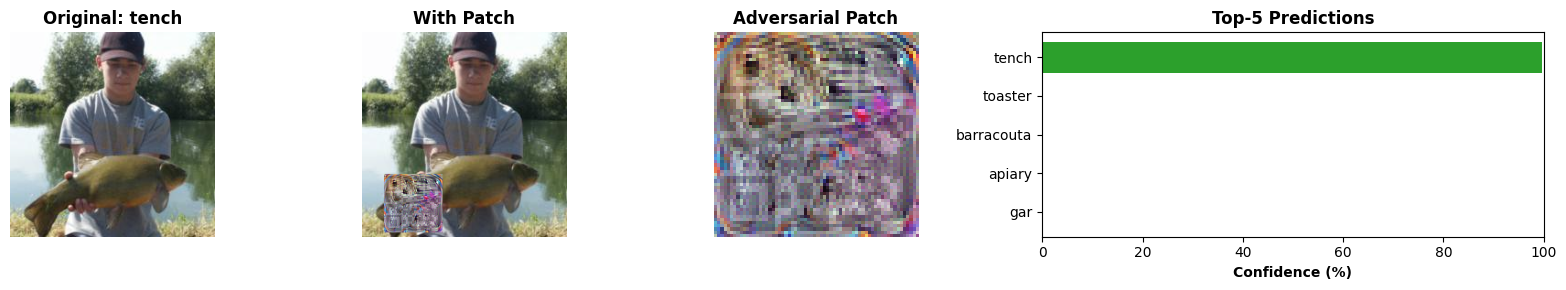


STEP 5: SAVING PATCHES FOR PRINTING

✓ Patch saved: 'toaster_original.png'
  Size: 4x4 inches at 300 DPI
  Resolution: 1200x1200 pixels

✓ Patch saved: 'toaster_styled.png'
  Size: 4x4 inches at 300 DPI
  Resolution: 1200x1200 pixels


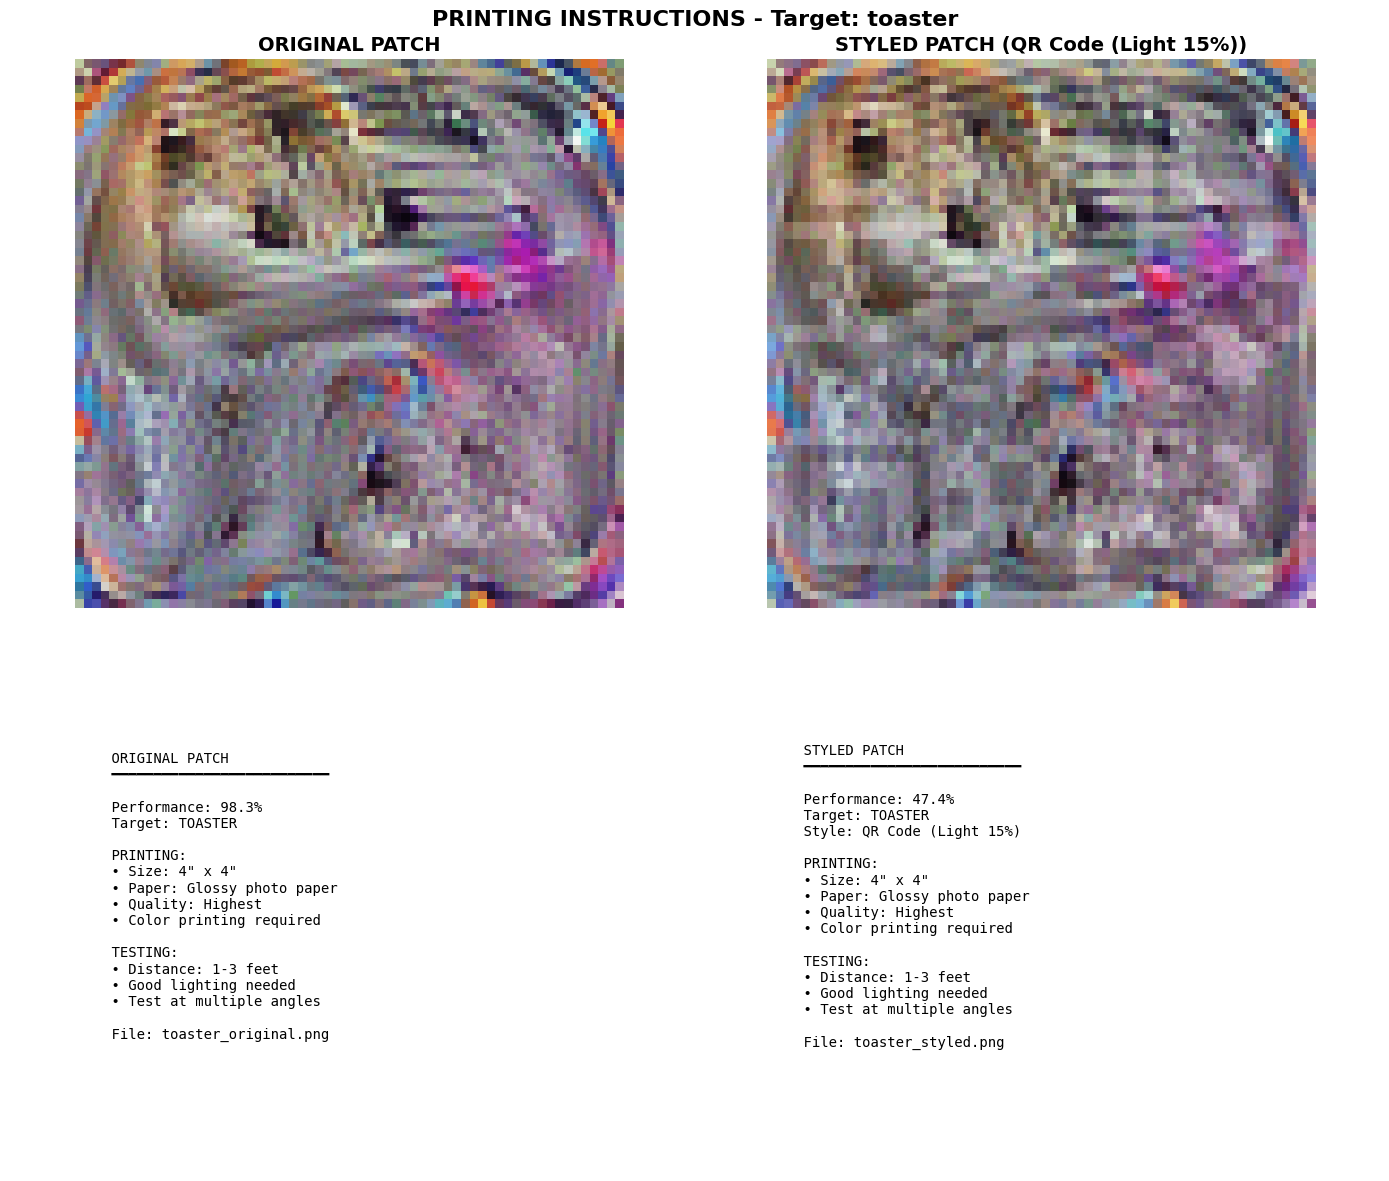


✓ Instruction sheet saved: 'toaster_instructions.png'

✨ FINAL SUMMARY ✨

🎯 Target: toaster

📊 ORIGINAL PATCH:
   • Success rate: 98.3%
   • Top-5 rate: 99.9%
   • File: toaster_original.png

🎨 STYLED PATCH (QR Code (Light 15%)):
   • Success rate: 47.4%
   • Top-5 rate: 77.3%
   • Performance drop: 50.9%
   • File: toaster_styled.png

⚠️ OVERALL RATING: MODERATE
   Consider using lighter styling or original patch.

💡 Consider: Original patch or lighter styling for better performance

📁 Files ready for physical testing!



In [11]:
results = main()